In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
import pandas as pd
import numpy as np
import json
import itertools

In [78]:
from utils import *

### Task

Наша задача - кластеризовать модели так, чтобы внутри каждого кластера лежали модели только одного класса. Нам априори известно разделение моделей на классы. Из этого следует 2 пункта:

- #### metrics

Будем оценивать качество кластеризации с помощью **внешней** меры: например, выберем [Индекс Rand](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html#:~:text=The%20Rand%20Index%20computes%20a,the%20predicted%20and%20true%20clusterings.), который принимает значения в [0, 1].

- #### algorithm

Поскольку нам заранее известно число кластеров, можем выбрать **KMeans** в качестве алгоритма кластеризации.


### Pipeline

Для решения задачи нам необходимо подобрать функцию расстояния между моделями. Исследуем 2 направления:

- #### Distance metric learning
- #### Аналитический подход к сравнению 3д моделей

### Labels

Посмотрим на распределение моделей по классам

In [6]:
labels = pd.read_csv("labels_clean.csv")

labels

,model,type
0,30a730ca-c466-4e8c-b00b-bf7b317495e2,Cone
1,1b220e0b-d7fa-40a0-8cfd-930a3228c668,Sphere
2,347130e7-e4ad-4714-a322-dadd515433f7,Torus
3,1346fe51-b6f1-4036-a2c4-cdf84abf6c85,Cone
4,1715abb8-f4e4-4eb3-a030-6c5b0083f1f0,Cylinder
...,...,...
2132,136a3a19-9b09-4e4b-8841-facf47b9abc5,Torus
2133,1e220704-e5d5-4596-864a-2fd3ab48fcbe,Sphere
2134,14ae3c6a-867e-4814-821b-1993979f4a23,Sphere
2135,222bdb7d-32e4-4499-988f-b91d0c7018c3,Cone


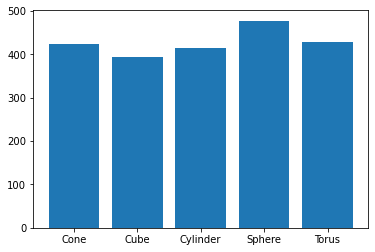

In [7]:
types, counts = np.unique(labels.type, return_counts=True)

bar_chart(types, counts)

### Histograms

Каждой модели по имени сопоставим датафрейм из гистограмм: 
- строка: тип гистограммы (первые 4 типа - основные)
- столбец: размерность гистограммы

In [8]:
model_names = labels.model
hist_path = "histograms"
dct = get_dct(model_names, hist_path)

dct['30a730ca-c466-4e8c-b00b-bf7b317495e2']

,8,16,32,64,128
model_bounding_sphere_strict_outer,"[0.02478889563441691, 0.17940145703405266, 0.2...","[0.003225895468844859, 0.02156300016557205, 0....","[8.968486119543021e-05, 0.003136210607649429, ...","[0, 8.968486119543021e-05, 0.00094514046029030...","[0, 0, 0, 8.968486119543021e-05, 0.00043600640..."
model_bounding_sphere_strict_outer_absolute,"[0.004952419176552117, 0.035841500533943894, 0...","[0.0006444815782466242, 0.004307937598305493, ...","[1.791758023354601e-05, 0.0006265639980130782,...","[0, 1.791758023354601e-05, 0.00018882373015352...","[0, 0, 0, 1.791758023354601e-05, 8.71070054430..."
model_bounding_sphere_missed,"[0, 0, 0.0653525605915613, 0.149977161258053, ...","[0, 0, 0, 0, 0.006309417760204922, 0.059043142...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0063094177602049...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
model_bounding_sphere_concentric_sphere,"[0.01962304762956013, 0.09995032838456869, 0.1...","[0.0047243225343562, 0.01489872509520393, 0.02...","[0.0010679397317732767, 0.003656382802582924, ...","[0.0001503946133892599, 0.0009175451183840168,...","[0, 0.0001503946133892599, 0.00039461338925989..."
hull_bounding_sphere_strict_outer,"[0.006622334729917468, 0.04830570366424873, 0....","[0.000543624492754419, 0.006078710237163049, 0...","[1.6473469477406637e-05, 0.0005271510232770124...","[0, 1.6473469477406637e-05, 0.0001372789123117...","[0, 0, 0, 1.6473469477406637e-05, 2.7455782462..."
hull_bounding_sphere_strict_outer_absolute,"[0.0006648800542048151, 0.004849875486600131, ...","[5.4579705942186307e-05, 0.0006103003482626287...","[1.6539304830965549e-06, 5.2925775459089756e-0...","[0, 1.6539304830965549e-06, 1.3782754025804624...","[0, 0, 0, 1.6539304830965549e-06, 2.7565508051..."
hull_bounding_sphere_missed,"[0, 0, 0.058188447985291866, 0.134055461927378...","[0, 0, 0, 0, 0.00561237934732649, 0.0525760686...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0056123793473264...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
hull_bounding_sphere_concentric_sphere,"[0.036645232852491064, 0.2136856093261802, 0.2...","[0.0072510721483051545, 0.02939416070418591, 0...","[0, 0.0072510721483051545, 0.01214643816134116...","[0, 0, 0.0030887755270137445, 0.00416229662129...","[0, 0, 0, 0, 0.0013480789189011097, 0.00174069..."


### Train dataset

Сформируем тренировочный датасет - каждой модели сопоставим:
- реальный класс
- вектор гистограмм, с помощью которых будем измерять расстояние между моделями
      
Вектор гистограм можно сформировать 2-мя способами:

- ```_type='concatenate_all'``` - конкатенирует все гистограммы с размером ```_intervals```
- ```_type='analytic'``` - 2-мерная матрица, каждая строка которой - гистограмма размера ```_intervals``` одного из восьми возможных типов. То, какие именно выбрать типы, можно задать с помощью параметра ```idx```

In [10]:
train_df = form_dataset(dct, labels, _type='concatenate_all', _intervals=128)

train_df

,model,type,vectors
0,30a730ca-c466-4e8c-b00b-bf7b317495e2,Cone,"[0.0, 0.0, 0.0, 8.968486119543021e-05, 0.00043..."
1,1b220e0b-d7fa-40a0-8cfd-930a3228c668,Sphere,"[0.0, 0.0, 0.0, 0.0012413227249569968, 0.00642..."
2,347130e7-e4ad-4714-a322-dadd515433f7,Torus,"[0.0, 0.0, 0.0, 0.0017943360086115465, 0.00786..."
3,1346fe51-b6f1-4036-a2c4-cdf84abf6c85,Cone,"[0.0, 0.0, 0.0, 1.4641538532869035e-05, 0.0002..."
4,1715abb8-f4e4-4eb3-a030-6c5b0083f1f0,Cylinder,"[0.0, 0.0, 0.0, 6.890738526920353e-05, 0.00048..."
...,...,...,...
2132,136a3a19-9b09-4e4b-8841-facf47b9abc5,Torus,"[0.0, 0.0, 0.0, 3.915937867119175e-05, 0.00187..."
2133,1e220704-e5d5-4596-864a-2fd3ab48fcbe,Sphere,"[0.0, 0.0, 0.0, 0.003804431815147658, 0.020577..."
2134,14ae3c6a-867e-4814-821b-1993979f4a23,Sphere,"[0.0, 0.0, 0.0, 0.001404506572808666, 0.006497..."
2135,222bdb7d-32e4-4499-988f-b91d0c7018c3,Cone,"[0.0, 0.0, 0.0, 0.00019669353637874622, 0.0010..."


### [Distance metric learning](http://contrib.scikit-learn.org/metric-learn/supervised.html)

In [68]:
from metric_learn import NCA, LMNN, MLKR

Выберем лучшую модель на пробной гистограмме длины 8 (для большей скорости подсчета)

In [70]:
intervals = [8]
dist_learners = [NCA, MLKR, LMNN]

best_search_dist_learn(intervals, dist_learners, dct, labels)

learner: NCA | histogram intervals: 8
Rand index: 0.703289991394706


learner: MLKR | histogram intervals: 8
Rand index: 0.6807107341840481


learner: LMNN | histogram intervals: 8
Rand index: 0.694790730118003




Выберем лучшую гистограмму для данной модели

In [71]:
_intervals = [8, 16, 32, 64, 128]
_dist_learners = [NCA]

best_search_dist_learn(_intervals, _dist_learners, dct, labels)

learner: NCA | histogram intervals: 8
Rand index: 0.703289991394706

learner: NCA | histogram intervals: 16
Rand index: 0.6749744557721192

learner: NCA | histogram intervals: 32
Rand index: 0.685951463338118

learner: NCA | histogram intervals: 64
Rand index: 0.690008307350954

learner: NCA | histogram intervals: 128
Rand index: 0.6897274522896917




Лучший результат получается на гистограммах размера 8 с алгоритмом NCA. Посмотрим на распределение классов по кластерам

--- cluster: 0 ---


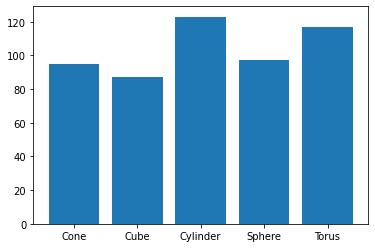

--- cluster: 1 ---


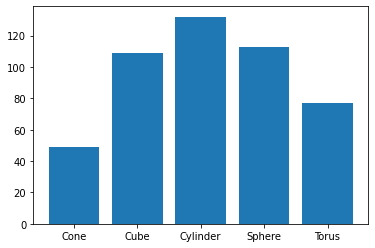

--- cluster: 2 ---


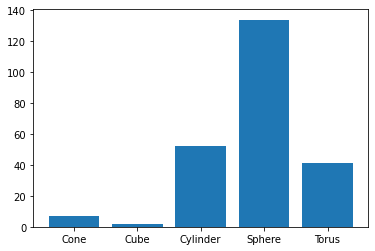

--- cluster: 3 ---


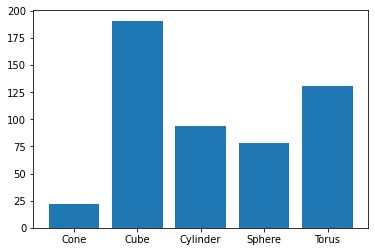

--- cluster: 4 ---


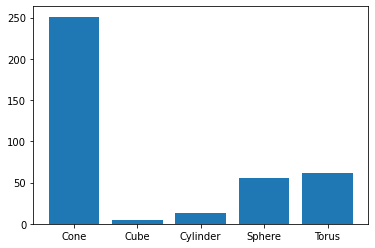

Rand index: 0.703289991394706



In [100]:
train_df = form_dataset(dct, labels, _type='concatenate_all', _intervals=8)
learner = NCA

dist_learn_df = clusterize_dist_learn(train_df, learner, bar=True)

Как видно, получилось выделить только 1 относительно чистый кластер с доминирующим типом "Cone"

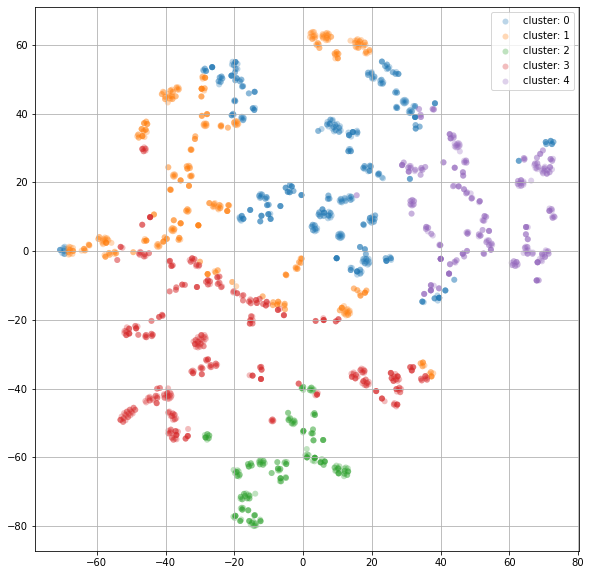

In [101]:
show_clusters(dist_learn_df, mode="TSNE")

### Analytic distance

Попробуем сравнить результаты для следующих гиперпараметров (везде размер гистограммы = 8):
    
    
- все 8 типов гистограмм

- первые 4 типа гистограмм
- последние 4 типа гистограмм


- все подвыборки из первых 4х типов гистограмм 
- все подвыборки из последних 4х типов гистограмм 

In [95]:
intervals_ = [8]

idx_ = [np.linspace(0, 7, 8, dtype=int),
        np.linspace(0, 3, 4, dtype=int), 
        np.linspace(4, 7, 4, dtype=int)]

for k in range(1, 4):
    idx_.extend(C(4, k))
    
for k in range(1, 4):
    idx_.extend(C(4, k) + 3)
    
print(idx_)
print()

best_search_analytic(intervals_, idx_, dct, labels)

[array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3]), array([4, 5, 6, 7]), array([0]), array([1]), array([2]), array([0, 1]), array([0, 2]), array([1, 2]), array([0, 1, 2]), array([3]), array([4]), array([5]), array([3, 4]), array([3, 5]), array([4, 5]), array([3, 4, 5])]

idx: [0 1 2 3 4 5 6 7] | histogram intervals: 8 | coeffs: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
Rand index: 0.6664694985269349


idx: [0 1 2 3] | histogram intervals: 8 | coeffs: [0.25, 0.25, 0.25, 0.25]
Rand index: 0.6897953657600437


idx: [4 5 6 7] | histogram intervals: 8 | coeffs: [0.25, 0.25, 0.25, 0.25]
Rand index: 0.6660291563482007


idx: [0] | histogram intervals: 8 | coeffs: [1.0]
Rand index: 0.6810095534535971


idx: [1] | histogram intervals: 8 | coeffs: [1.0]
Rand index: 0.6856855054251909


idx: [2] | histogram intervals: 8 | coeffs: [1.0]
Rand index: 0.6653565939160047


idx: [0 1] | histogram intervals: 8 | coeffs: [0.5, 0.5]
Rand index: 0.6844586814446378


idx: [0 2] | histogram

Выберем лучший размер гистограммы для данной комбинации фичей

In [96]:
_intervals_ = [8, 16, 32, 64, 128]
_idx_ = [np.array([0, 1, 2])]

best_search_analytic(_intervals_, _idx_, dct, labels)

idx: [0 1 2] | histogram intervals: 8 | coeffs: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Rand index: 0.6921854817650142

idx: [0 1 2] | histogram intervals: 16 | coeffs: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Rand index: 0.691052422188689

idx: [0 1 2] | histogram intervals: 32 | coeffs: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Rand index: 0.6904644229808669

idx: [0 1 2] | histogram intervals: 64 | coeffs: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Rand index: 0.6923769539362647

idx: [0 1 2] | histogram intervals: 128 | coeffs: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Rand index: 0.6923331387941021




Лучший результат получается на гистограммах размера 64 с гистограммами [0, 1, 2], то есть:

- ```model_bounding_sphere_strict_outer```
- ```model_bounding_sphere_strict_outer_absolute```
- ```model_bounding_sphere_missed```

Посмотрим на распределение классов по кластерам

--- cluster: 0 ---


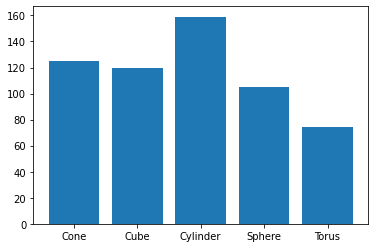

--- cluster: 1 ---


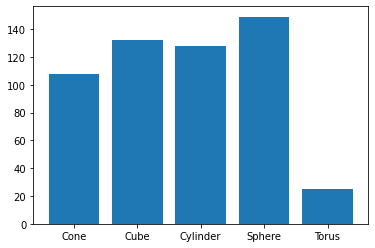

--- cluster: 2 ---


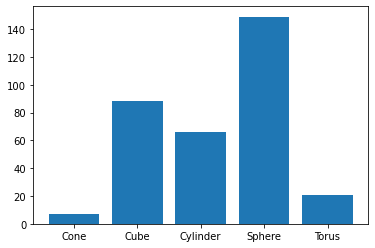

--- cluster: 3 ---


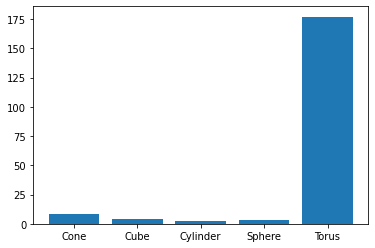

--- cluster: 4 ---


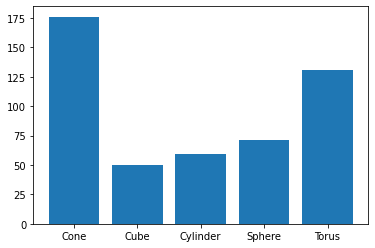

Rand index: 0.6923769539362647



In [98]:
_train_df_ = form_dataset(dct, labels, _type='analytic', idx=[0, 1, 2], _intervals=64)
_coefs_ = np.array([1/3, 1/3, 1/3])
cust_distance = AnalyticDistance(_coefs_)

analytic_df = clusterize_analytic(_train_df_, cust_distance, bar=True)

Результат аналогичен предыдущему: только один относительно чистый кластер с доминирующим типом "Torus"

### Discussion

Кластеризация с помощью distance metric learning и с помощью аналитического подхода дает сравнимые результаты. Внешнее качество кластеризации, измеренное с помощью индекса Rand, равно ~0.70 и ~0.69 соответственно. Распределение классов по кластерам оставляет желать лучшего.